The amount of data humanity generated in the years of 2014 and 2015 was equal to all that was generated in all of the previous years before. This new paradigm is sometimes called the age of Big Data and Internet of Things (IoT), in which data is not only being generated by individuals but also by "things". 

The energy sector is an important member of this new era because one of these "things" is the smart meter — a small computer that measures the amount of energy being consumed by a house, building or factory in real time. 

All this data offers a unique opportunity to better understand the behavior of energy consumers. This can be achieved by utilizing artificial intelligence tools that segment consumers into clusters of similarity. Each cluster contains energy consumption patterns that are similar to each other — this is sometimes called an "energy footprint". In crude terms, it is the way one individual or family uses energy during the day. 

By segmenting energy profiles, utilities can determine specific tariffs according to the type of consumer. This, in turn, is a type of measure that can improve energy efficiency across the grid, which is of great importance in a context of a worldwide transition to a low-carbon economy.

This mini-project applies a clustering algorithm (K-means) to segment electricity load profiles into clusters. The data of energy consumption is from the [Pecan Street Energy Database](http://www.pecanstreet.org/), a project coordinated by the University of Texas at Austin in which more than 500 houses across the state of Texas have their energy consumption measured by smart meters every minute. 

Here I will only use data of 216 households collected during July of 2015.

## Import necessary libraries

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib import pylab
import seaborn as sns
import sqlite3

plt.style.use('fivethirtyeight')

## Get data from DataBase

In [2]:
# I stored the data that I retrieved from 
# the Dataport Database into an SQLite database file. 
cwd = os.getcwd()
conn = sqlite3.connect(str(cwd) + "/dataport_sqlite") 
cursor = conn.cursor()
query = "SELECT * FROM new_table;"
cursor.execute(query)
data = cursor.fetchall()

## Load result in a Pandas DataFrame

In [3]:
loads_df = pd.DataFrame(data, columns=['id','date','energy_use'])
loads_df.head() 

,id,date,energy_use
0,26,2015-08-01 00:00:00,1.4090666666666667
1,26,2015-07-31 23:45:00,3.1387333333333333
2,26,2015-07-31 23:30:00,4.2021333333333333
3,26,2015-07-31 23:15:00,4.2418000000000000
4,26,2015-07-31 23:00:00,4.2857333333333333


The energy consumption measurements are spaced by 15 minutes.Column 'id' represents the id of the house, 'date' the date and time of measurement and 'energy_use' the measured power in kW.

In [4]:
print("The dataframe contains {:,} rows and {} columns"
      .format(loads_df.shape[0],loads_df.shape[1]))

The dataframe contains 646,981 rows and 3 columns


In [5]:
print(" min timestamp: {} \n max timestamp: {}".format(loads_df.date.min(),loads_df.date.max()))

 min timestamp: 2015-07-01 00:00:00 
 max timestamp: 2015-08-01 00:00:00


## Cleaning the data

### We got missing values in the form of empty strings

In [6]:
loads_df = loads_df.replace('',np.nan)
loads_df.isnull().sum() 

id                0
date              0
energy_use    10695
dtype: int64

### Let's remove them

In [7]:
loads_df = loads_df.dropna()

### Transform datatypes

In [8]:
# transfrom load consumption values into into float
loads_df.loc[:,'energy_use'] = loads_df.energy_use.astype(float) 

# transfrom id column to integer
loads_df.loc[:,'id'] = loads_df['id'].astype(int) 

# transfrom date into datetime
loads_df.loc[:,'date'] = pd.to_datetime(loads_df.date) 

### Create columns with an integer that represents the day of the month and the month of the year for each row

The data is not exactly in the way I want it. To be able to compare the similarities between each load profile I must have each of them stored in a single array. In other words, I want to have several arrays of load profiles for each day for any given house but I have all the data grouped into one single column. Creating columns with the day of the month and the month of the year as integers will facilitate the process of filtering.

In [9]:
# create a column that contains info if 
# the observation is on a weekday or a weekend
loads_df.loc[:,'type_day'] = loads_df.date.apply(lambda x: x.isoweekday()) 

# create a column of the day of the 
# month for a particular observation
loads_df.loc[:,'day_of_month'] = loads_df.date.apply(lambda x: x.day) 

# sort values and reset index
loads_df = loads_df.sort_values(['id', 'date'], ascending=[True, True])
loads_df = loads_df.reset_index(drop=True)

### Filter the weekends 

Excluding the load-profiles of weekends makes our dataset more homogeneous and easier for cluster creation.

In [10]:
# select only weekdays
loads_df = loads_df[(loads_df['type_day'] != 6) & (loads_df['type_day'] != 7)] 

###  How many unique homes in the dataset?

In [16]:
print("there are {} different homes".format(loads_df.id.nunique())) 

there are 216 different homes


### Transform dataframe from long to wide

In [17]:
loads_wide_df = pd.pivot_table(data=loads_df,
                               columns=['date','day_of_month'],
                               values='energy_use',
                               index=['id'])
unique_days = loads_df.day_of_month.unique()
loads_wide_df = pd.concat([loads_wide_df.xs(10,level='day_of_month',axis=1) 
                           for day in unique_days])

### Let's check if some households have missing measurements 

In [18]:
(loads_wide_df.T.isnull().sum()).groupby('id').unique().sort_values(ascending=False).head()

id
1508    [96]
1283     [0]
1507     [0]
1500     [0]
1463     [0]
dtype: object

yup, house 1508 has 96 missing measurements, for the sake of simplicity let's remove her


In [19]:
loads_wide_df = loads_wide_df.dropna(axis=0,how='any')

In [20]:
print("There are",loads_wide_df.shape[0],
      "daily-loads in the dataset. Each containing",
      loads_wide_df.shape[1] ,"load measurements.")

There are 4945 daily-loads in the dataset. Each containing 96 load measurements.


## How does a daily-load profile look like?
Lets plot them for some random houses

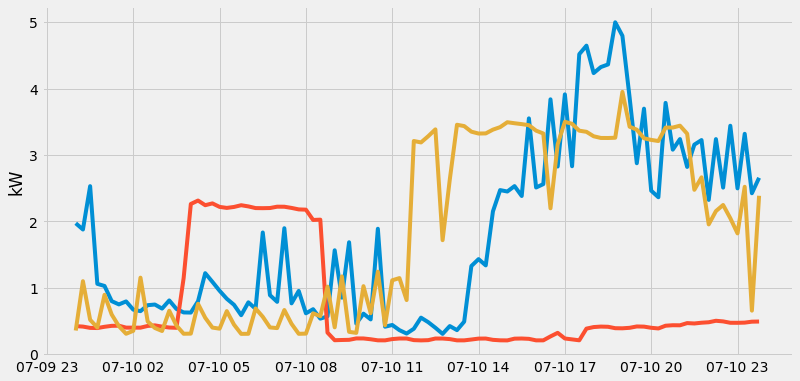

In [21]:
pylab.rcParams['figure.figsize'] = 12, 6  
plt.plot(loads_wide_df.iloc[30])
plt.plot(loads_wide_df.iloc[123])
plt.plot(loads_wide_df.iloc[567])
plt.ylabel('kW')

plt.show()

### How would all 4945 load curves look like ploted together?

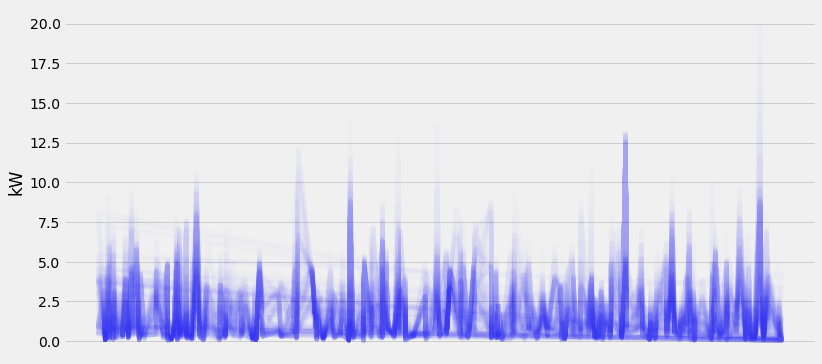

In [87]:
pylab.rcParams['figure.figsize'] = 12, 6  
plt.plot(loads_wide_df, color='blue',alpha=0.01)
plt.ylabel('kW')
plt.xticks([], [])
plt.show()

Quite a mess, huh? The creation of clusters will alow us to find structure that is not visible in all of those curves. 

## Perform cluster analysis  with K-means

The goal of clustering is to find subgroups or clusters in a dataset. Each subgroup contains elements that are similar to each other, thus one crucial point is to properly define what is similarity between two objects. One of the most popular clutering algorithms is called *K-means*.

The K-means algorithm belongs to a class of clustering technique known as *prototype clustering*. Each cluster is represented by a **centroid** *average* of similar points with continuous features. 

Given a set of clusters $C_1,...,C_K$, the K-means algorithm aims to minimize the *within-cluster variation* ($W(C_k)$), which is a measure of how much the observations within a cluster differ from each other. Therefore the problem resolves to:

$$\overset{minimize}{C_1,...,C_K}\left\{ \sum\limits_{j=1}^K W(C_k) \right\}$$

In which $W(C_k)$ is the squared euclidean distance between two vectors $(x,y)$ in an IR$^p$, given by: 
$$W(C_k)=\frac{1}{|C_k|} \sum\limits_{i,j\epsilon C_k} \sum\limits_{j=1}^p (x_{ij}-y_{ij})^2 $$

where $|C_k|$ is the number of observation in each cluster. In other words, "the within cluster variation for the *k*th cluster is the sum of all  of the pairwise  squared Euclidean distances between the observations in the *k*th cluster, divided by the total number of observations in each cluster". 

One of the challenges is to find the optimal number of clusters since there are $K^n$ ways to segment *n* observations into *K* clusters. However,the K-means algorithm provides an elegant, yet simple, solution to find a local optimal. The algorithm is summarized in the following four steps:

1. Randomly select $k$ centroids from the sample points as initial cluster centers;
2. Assign each sample to the nearest centroid $\mu^{(j)}$, $j \epsilon \left\{ 1,...,k \right\}$ (where nearest is measured by the square of the euclidean distance); 
3. Move the centroids to the center of the samples that were assigned to it; 
4. Repeat the steps 2 and 3 until the cluster assignments do not change or a maximum number of iterations is reached.

K-means clustering derives its name from the fact that in Step (2), the cluster centroids are computed as the mean of the observations assigned to each cluster.

## Optimal number of clusters

We need a metric to deterime what how many clusters *k* is the best choice. A common one is called distorsion ($W(C_k)$). If *k* increases the distortion will decrease because the samples will be closer to the centroids of their clusters. The **elbow method** is often used to estimate the optimal *k* as it's as graphical tool that helps to visualize the process. The main idea is to identify the value o *k* where the distortion begins to increase most rapidly. 

## Enough talking, let's get down to business

## Feature scaling

Feature scaling is a method used to standardize the range of independent variables or features of data.
The data wil be scaled into values between 0 and 1. 

In [27]:
from sklearn.preprocessing import normalize
load_data_scaled = normalize(loads_wide_df)

In [43]:
from sklearn.cluster import KMeans

class EnergyFingerPrints():
     
    def __init__(self,data):
        # will contain the centroid of each cluster
        self.means = [] 
        self.data = data

    def elbow_method(self,n_clusters):
        """Performs elbow method for a predefined number
        of clusters.
        
        Parameters
        ----------
        n_clusters : int
            the number of clusters to perform the elbow method
        
        Returns
        ---------
        A plot the of elbow method
        """
        pylab.rcParams['figure.figsize'] = 10, 6  
        distortions = []

        for i in range(1, n_clusters):
            km = KMeans(n_clusters = i, 
                        init='k-means++',
                        n_init=10, 
                        max_iter=300, 
                        random_state=0)
            km.fit(self.data)
            distortions.append(km.inertia_)
        
        plt.plot(range(1,n_clusters), distortions, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        plt.show() 
        
    def get_cluster_counts(self):
        return pd.Series(self.predictions).value_counts()
        
    def fit(self,n_clusters):
        """Performs K-means clustering for the load-profiles
        
        Parameters
        ----------
        n_clusters : int
        
        Returns
        --------
        count_dict : dict
            The number of load-profiles in each cluster
        """
        self.n_clusters = n_clusters
        self.kmeans = KMeans(self.n_clusters)
        self.predictions = self.kmeans.fit_predict(self.data)

    def plot(self):
        """Plots all loads in each cluster"""
        
        self.cluster_names = [str(x) for x in range(self.n_clusters)]
        pylab.rcParams['figure.figsize'] = 60, 80

        for i in range(0,self.n_clusters):
            all_data = [] 
            for x,y in zip(self.data,self.predictions):
                    if y == i:
                        all_data.append(x)
                        plt.subplot(4,1,i+1)
                        plt.plot(x,alpha=0.006,color="blue")
                        plt.ylim(0,0.6)
                        plt.xlim(0,96)
                        plt.title('Cluster {}'.format(i+1),fontsize=60)
                    
            all_data_array = np.array(all_data)
            mean = all_data_array.mean(axis=0)
            self.means.append(mean)
            plt.plot(mean, color="black",linewidth=4)
        
        plt.show()
        
    def plot_energy_fingerprints(self):
        """Plots the mean of each cluster in single plot"""
        pylab.rcParams['figure.figsize'] = 20, 12 
        
        for i,item in enumerate(self.means):
            plt.plot(item, label = "cluster {}".format(str(i+1)))
            plt.xlim(0,96)
        plt.legend()
        plt.show()

### Let's create an instance of EnergyFingerPrints

In [44]:
energy_clusters = EnergyFingerPrints(load_data_scaled)

### Run the elbow method

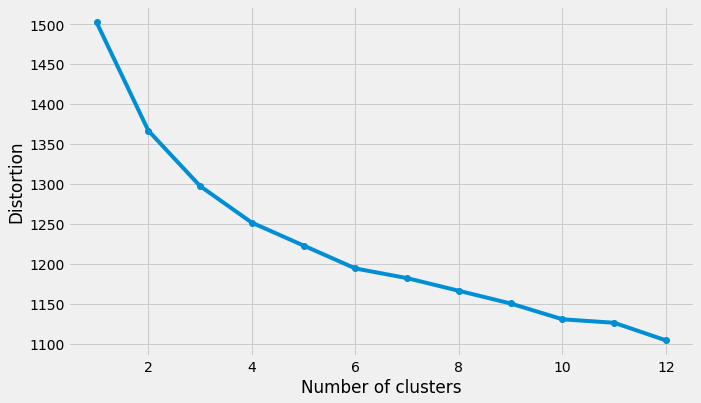

In [45]:
energy_clusters.elbow_method(n_clusters=13)

As *K* increases, the centroids are closer to the centroids of the clusters. At some point *K* the improvements decline creating the elbow shape. Four our case it looks like it's around 4. 

### Fit the model

In [46]:
energy_clusters.fit(n_clusters = 4)

### How may daily-loads in each cluster

In [47]:
energy_clusters.get_cluster_counts()

2    1656
3    1541
0    1196
1     552
dtype: int64

### Plot clusters

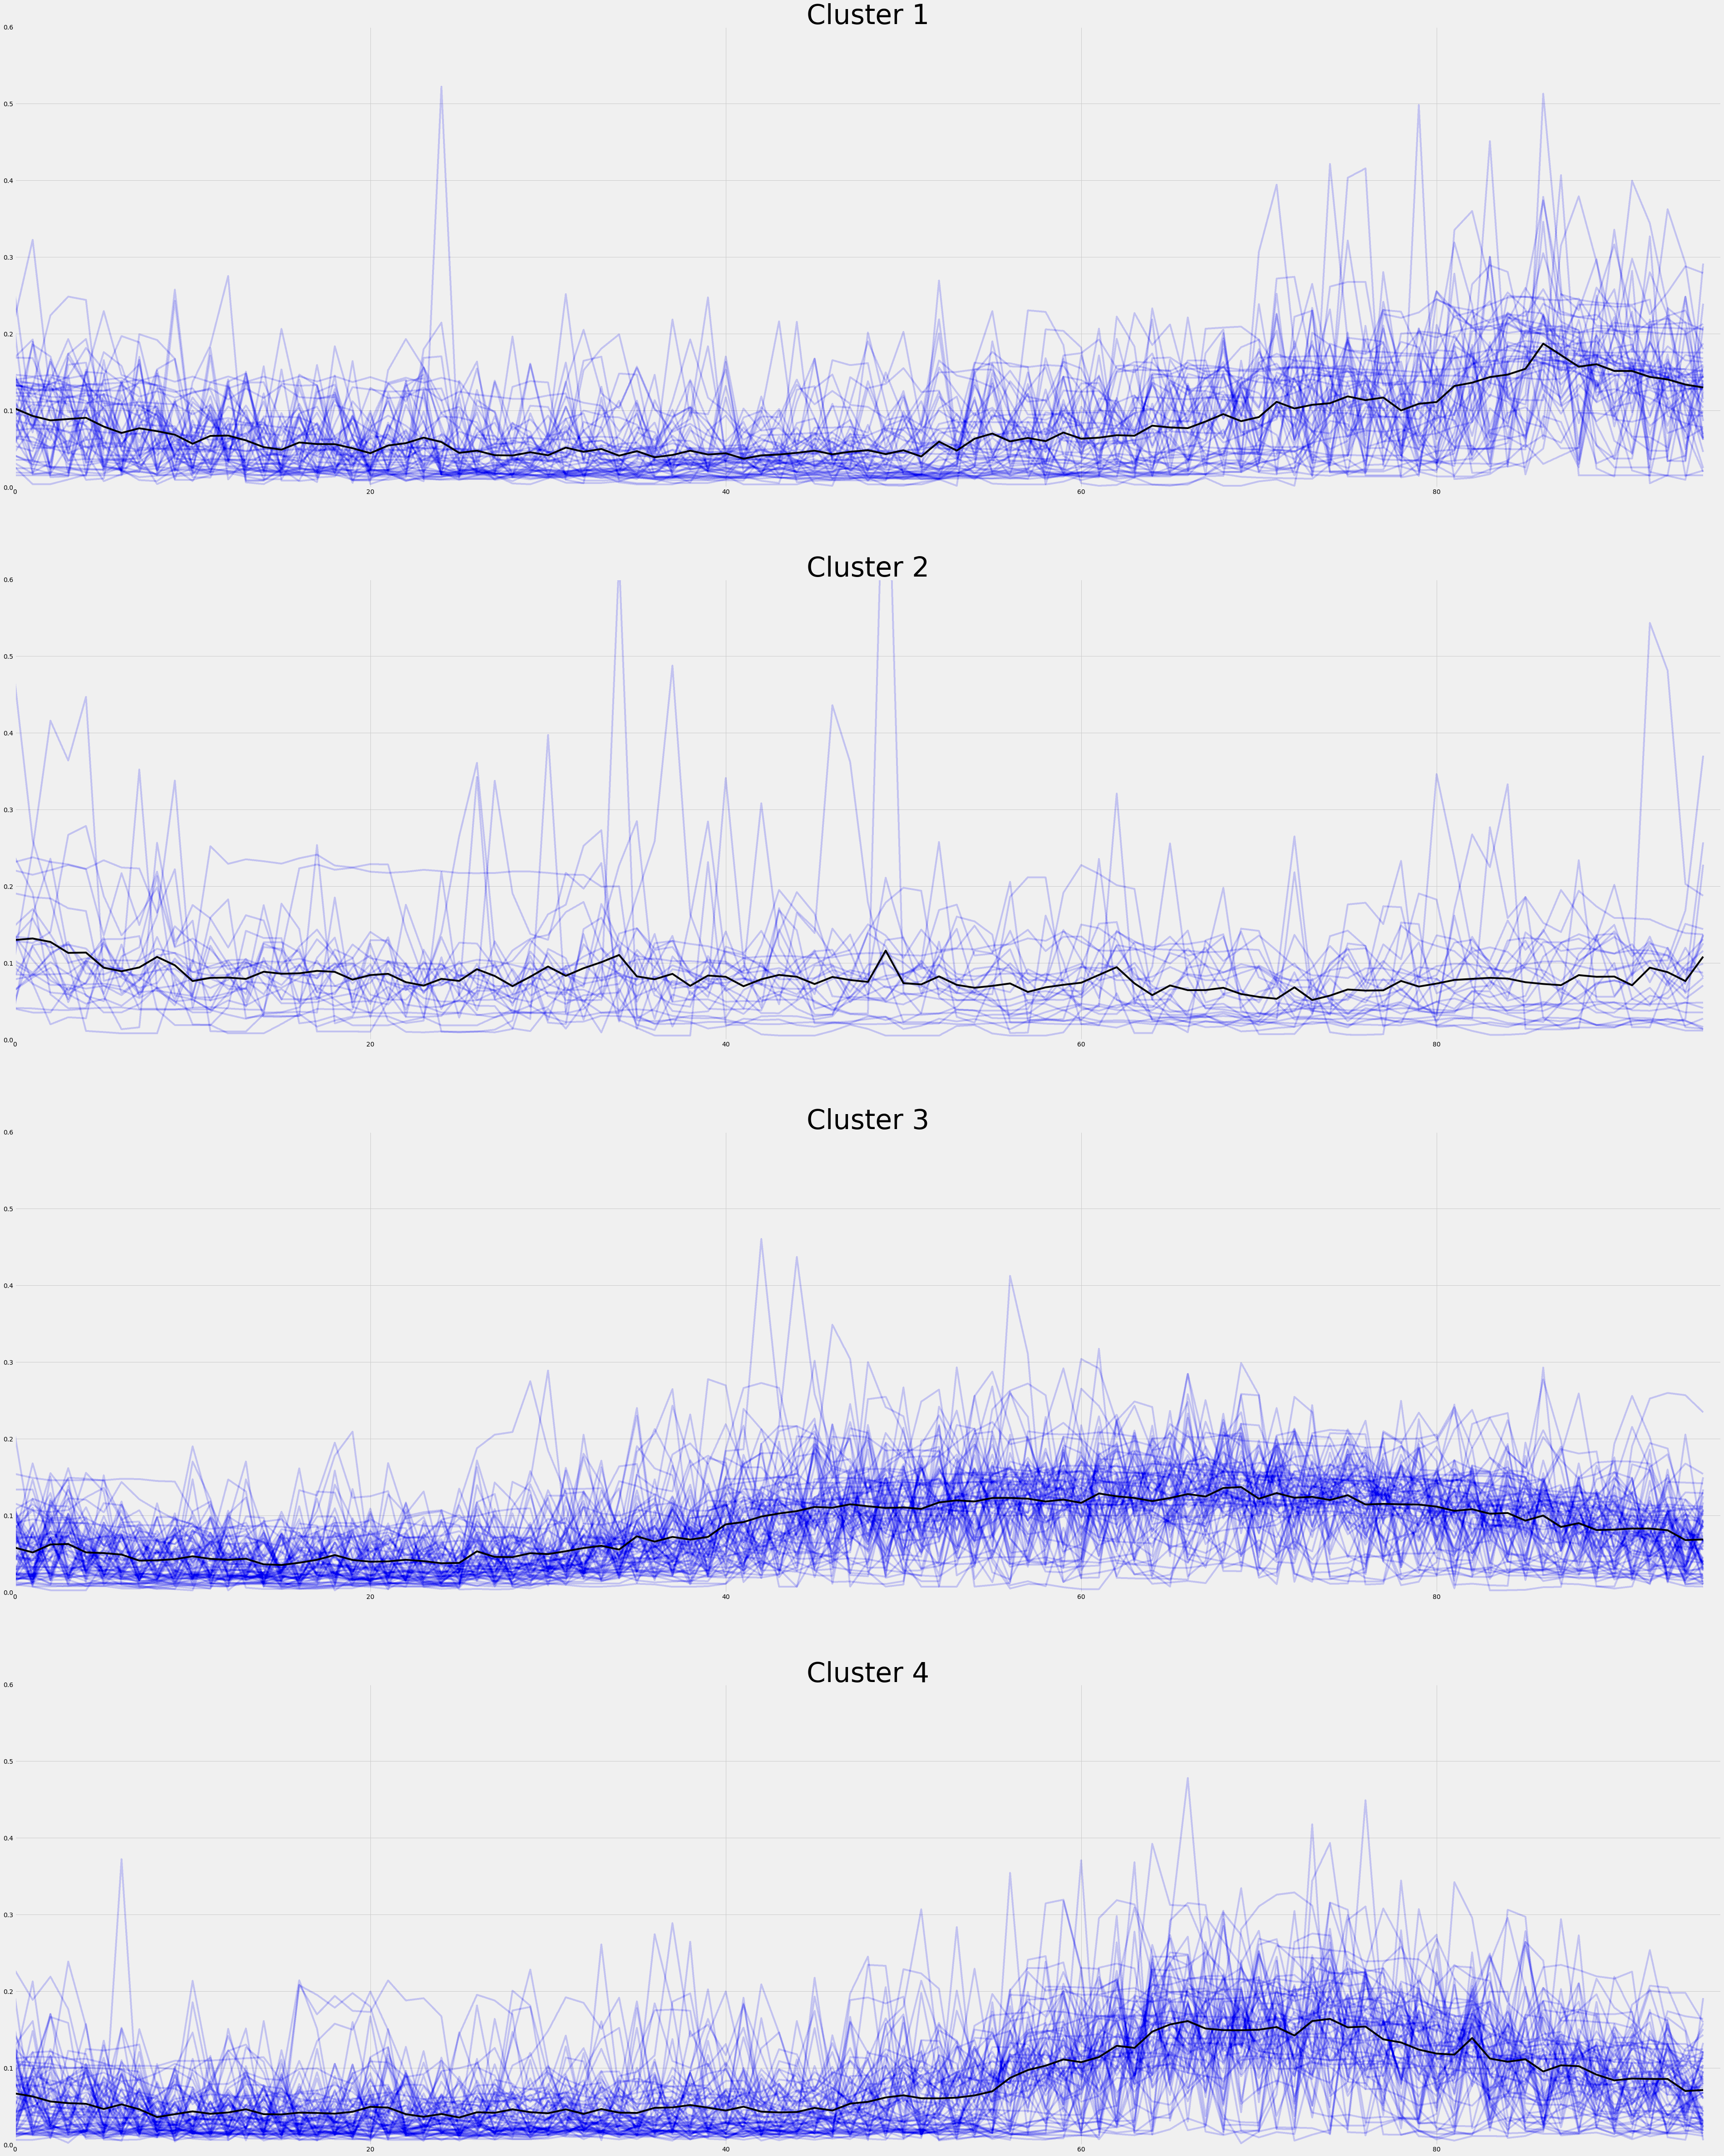

In [48]:
energy_clusters.plot()

## The energy fingerprints in one plot

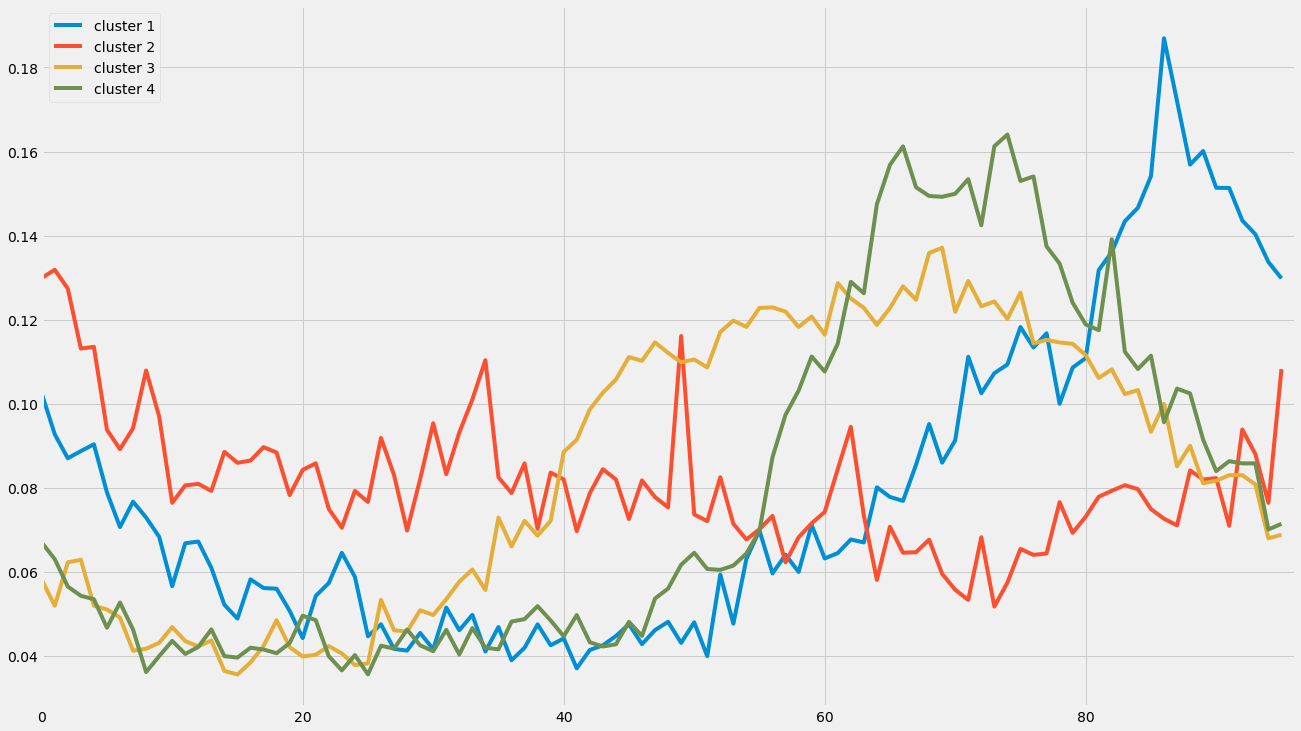

In [49]:
energy_clusters.plot_energy_fingerprints()